# Ukrainian V2 Dataset - Visual Inspection

**Purpose**: Verify that all line images are horizontal (no EXIF rotation issues)

**Dataset**:
- Training: 21,944 lines (674 pages)
- Validation: 814 lines (23 pages)
- EXIF check: 0 rotated images found

**Inspection**:
- 30 random training samples
- 15 random validation samples
- Check for vertical text (EXIF rotation bug)

In [2]:
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Set random seed for reproducibility
random.seed(42)

## Load Dataset

In [3]:
# Load training and validation data
train_df = pd.read_csv('data/pylaia_ukrainian_v2_train/train.csv', names=['image_path', 'text'])
val_df = pd.read_csv('data/pylaia_ukrainian_v2_val/train.csv', names=['image_path', 'text'])

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Total: {len(train_df) + len(val_df):,}")

Training samples: 21,944
Validation samples: 814
Total: 22,758


## Sample Random Images

In [4]:
# Sample 30 training + 15 validation
train_sample = train_df.sample(30, random_state=42)
val_sample = val_df.sample(15, random_state=42)

print(f"Sampled {len(train_sample)} training images")
print(f"Sampled {len(val_sample)} validation images")

Sampled 30 training images
Sampled 15 validation images


## Display Training Samples (30 images)

**What to look for**:
- ✅ Text baseline is horizontal
- ✅ Characters are upright (not 90° rotated)
- ✅ Reasonable aspect ratios (width >> height)
- ❌ Vertical text (letters sideways) = EXIF rotation bug

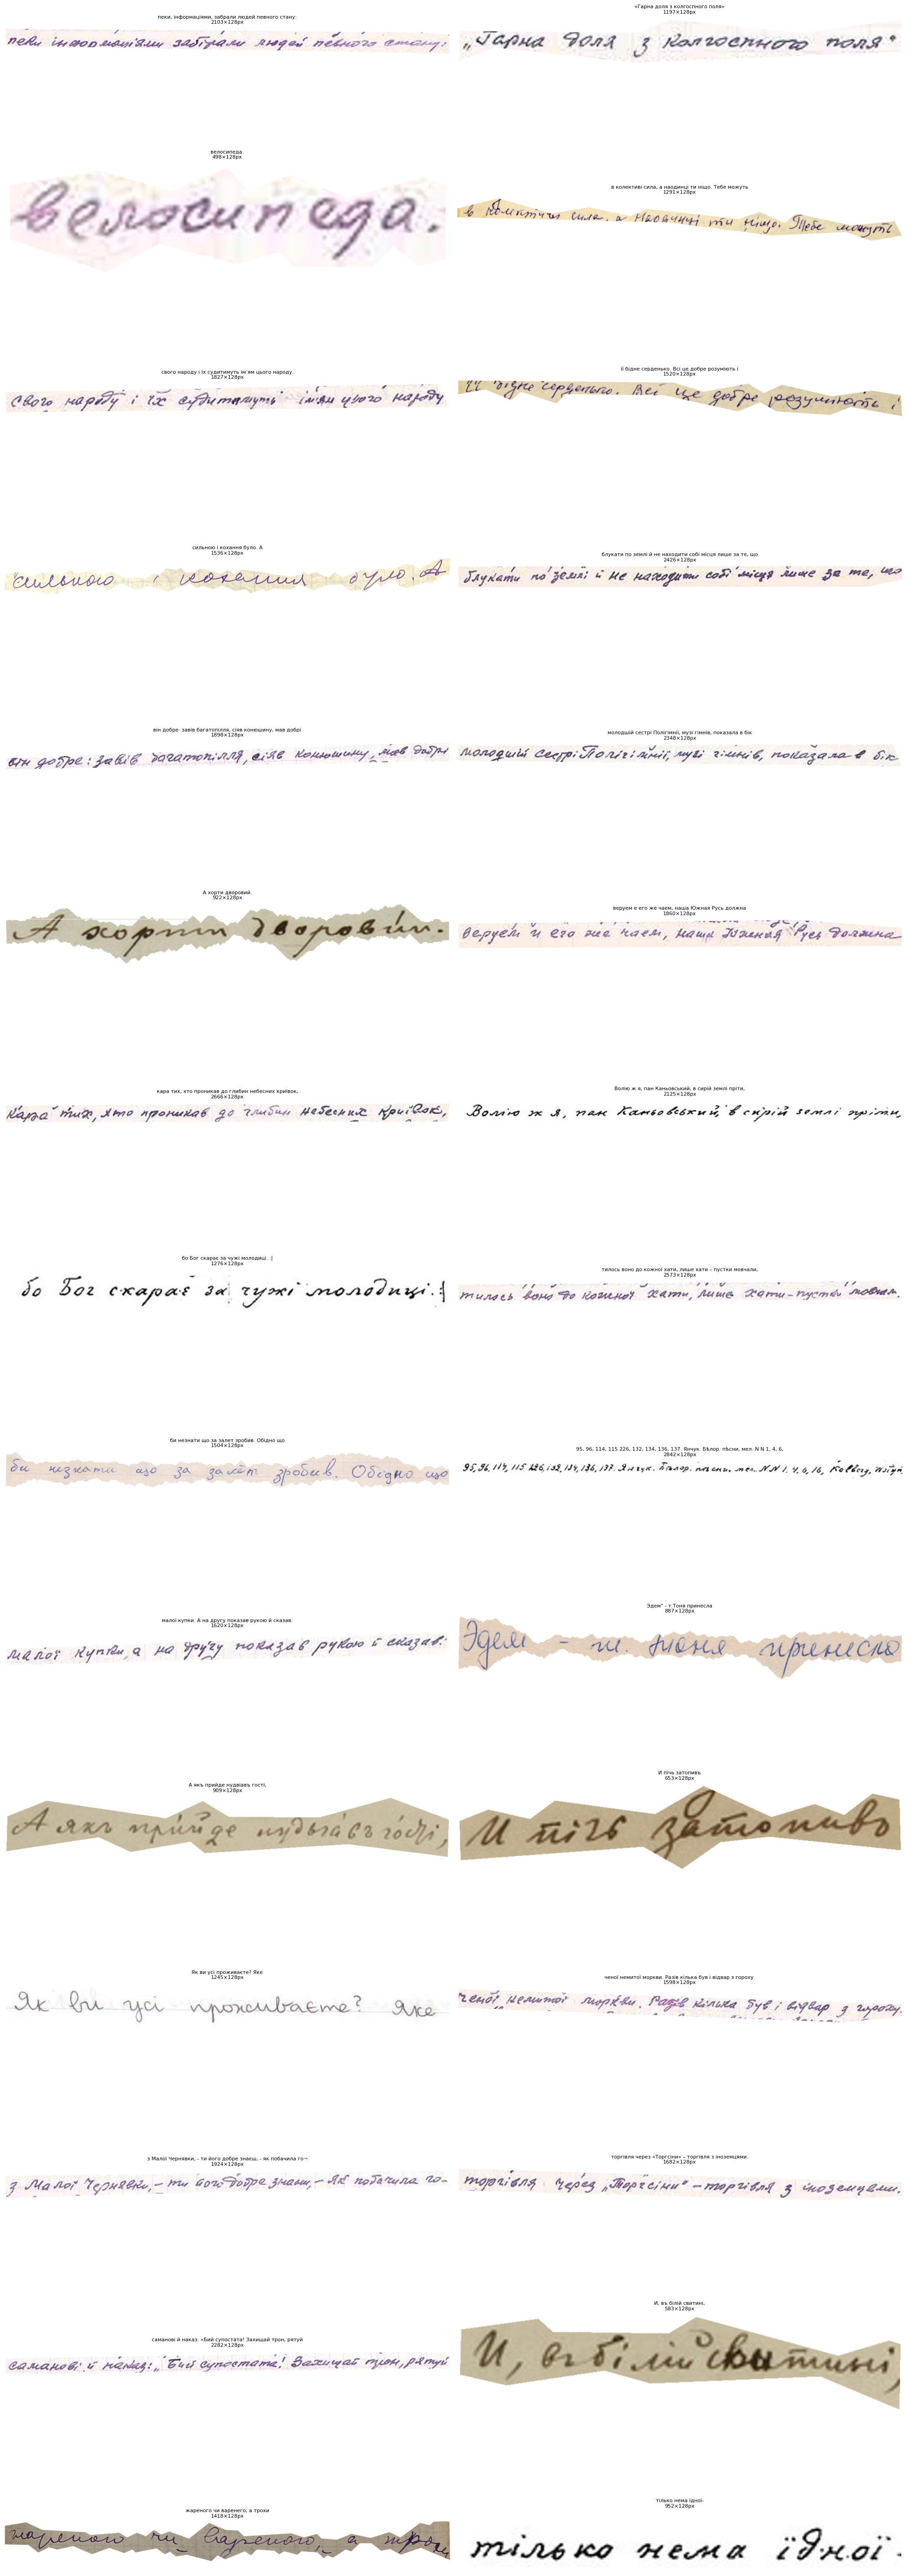

Training samples saved to: ukrainian_v2_train_samples.png


In [5]:
# Display training samples in a grid
fig, axes = plt.subplots(15, 2, figsize=(20, 60))
axes = axes.flatten()

for idx, (_, row) in enumerate(train_sample.iterrows()):
    img_path = Path('data/pylaia_ukrainian_v2_train') / row['image_path']
    
    try:
        img = Image.open(img_path)
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"{row['text'][:80]}\n{img.size[0]}×{img.size[1]}px", fontsize=8)
        axes[idx].axis('off')
    except Exception as e:
        axes[idx].text(0.5, 0.5, f"Error: {e}", ha='center', va='center')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig('ukrainian_v2_train_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training samples saved to: ukrainian_v2_train_samples.png")

## Display Validation Samples (15 images)

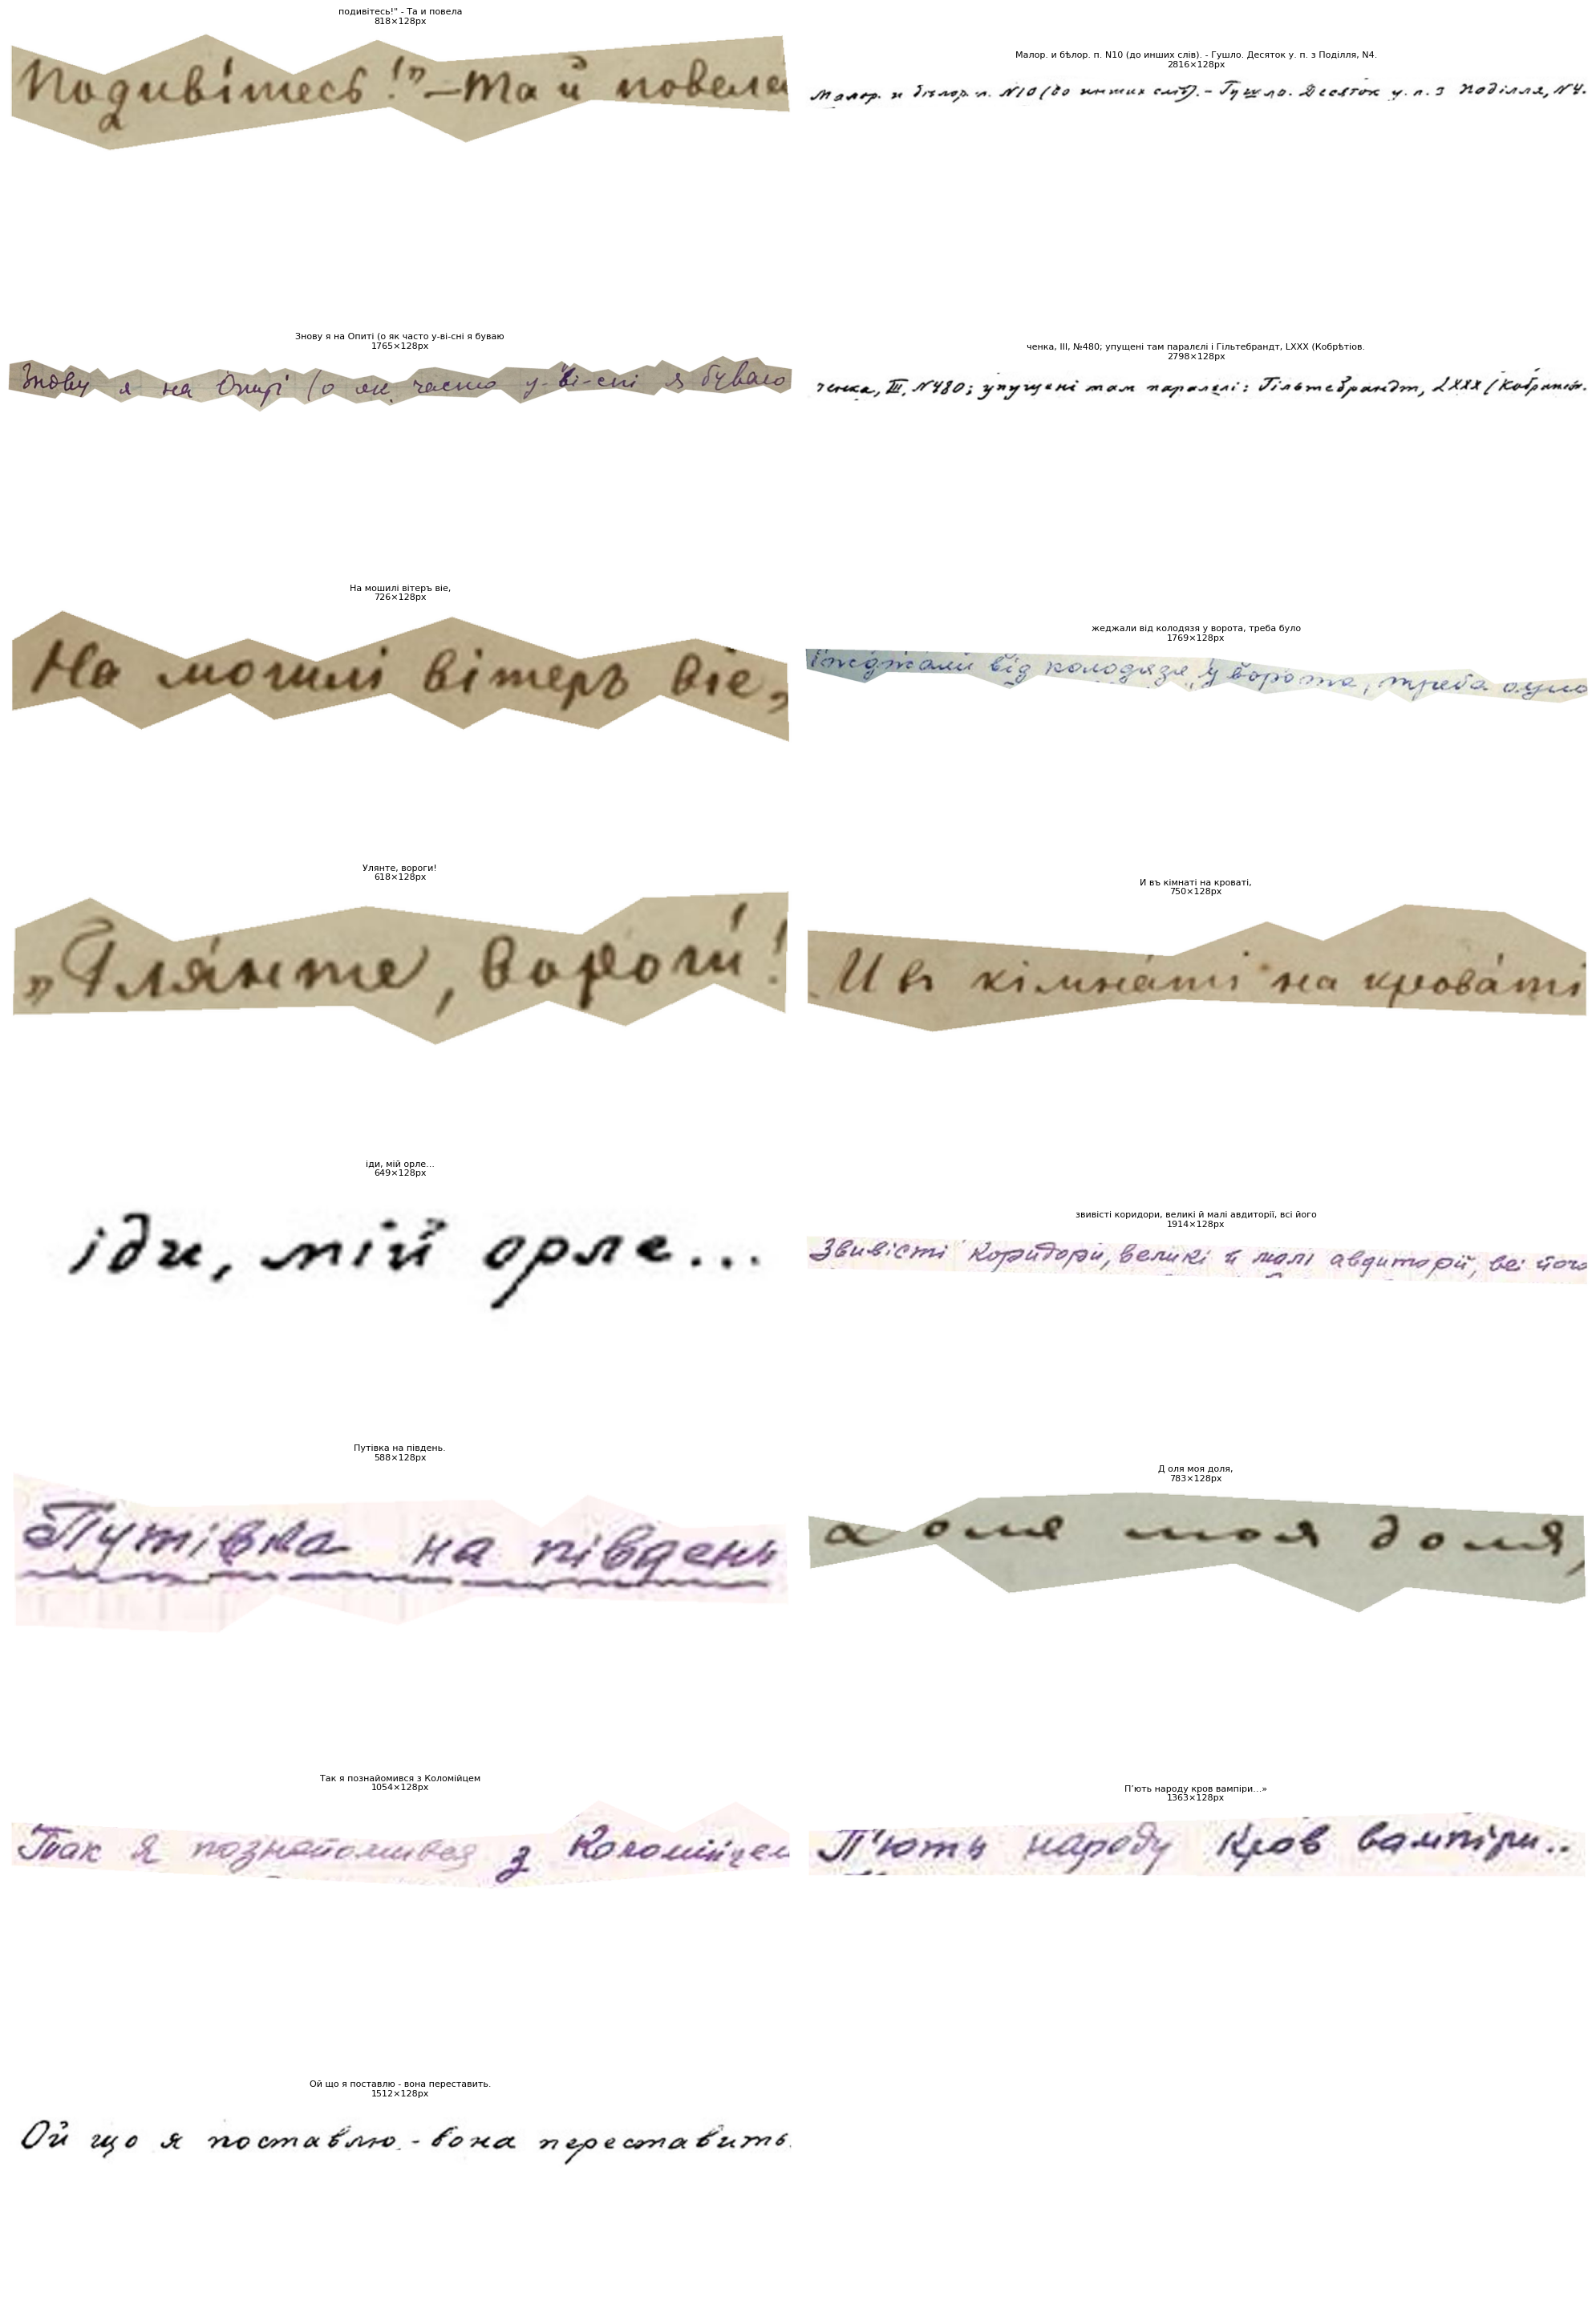

Validation samples saved to: ukrainian_v2_val_samples.png


In [6]:
# Display validation samples in a grid
fig, axes = plt.subplots(8, 2, figsize=(20, 30))
axes = axes.flatten()

for idx, (_, row) in enumerate(val_sample.iterrows()):
    img_path = Path('data/pylaia_ukrainian_v2_val') / row['image_path']
    
    try:
        img = Image.open(img_path)
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"{row['text'][:80]}\n{img.size[0]}×{img.size[1]}px", fontsize=8)
        axes[idx].axis('off')
    except Exception as e:
        axes[idx].text(0.5, 0.5, f"Error: {e}", ha='center', va='center')
        axes[idx].axis('off')

# Hide unused subplot
axes[15].axis('off')

plt.tight_layout()
plt.savefig('ukrainian_v2_val_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Validation samples saved to: ukrainian_v2_val_samples.png")

## Edge Gradient Analysis (Rotation Detection)

Detect vertical text by comparing horizontal vs vertical edge gradients.

**Ratio < 0.8** = likely rotated (vertical text)

In [7]:
def check_rotation(img_path):
    """Check if image has vertical text using edge gradient analysis."""
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)
    
    # Calculate gradients
    gy, gx = np.gradient(img_array.astype(float))
    
    # Ratio of horizontal to vertical edges
    ratio = np.abs(gx).sum() / (np.abs(gy).sum() + 1)
    
    return ratio

# Check all sampled images
flagged_images = []

print("Checking training samples...")
for _, row in train_sample.iterrows():
    img_path = Path('data/pylaia_ukrainian_v2_train') / row['image_path']
    ratio = check_rotation(img_path)
    
    if ratio < 0.8:
        flagged_images.append({
            'path': str(img_path),
            'ratio': ratio,
            'text': row['text'][:50],
            'split': 'train'
        })

print("Checking validation samples...")
for _, row in val_sample.iterrows():
    img_path = Path('data/pylaia_ukrainian_v2_val') / row['image_path']
    ratio = check_rotation(img_path)
    
    if ratio < 0.8:
        flagged_images.append({
            'path': str(img_path),
            'ratio': ratio,
            'text': row['text'][:50],
            'split': 'val'
        })

print(f"\n{'='*60}")
print(f"ROTATION CHECK RESULTS")
print(f"{'='*60}")
print(f"Total images checked: {len(train_sample) + len(val_sample)}")
print(f"Flagged as potentially rotated: {len(flagged_images)}")
print(f"Expected: 0 (EXIF check found 0 rotated images)")
print(f"Status: {'✅ PASS' if len(flagged_images) == 0 else '⚠️ REVIEW FLAGGED IMAGES'}")

if flagged_images:
    print(f"\n{'='*60}")
    print("FLAGGED IMAGES (ratio < 0.8):")
    print(f"{'='*60}")
    for img in flagged_images:
        print(f"[{img['split']}] {img['path']}")
        print(f"  Ratio: {img['ratio']:.2f}")
        print(f"  Text: {img['text']}")
        print()

Checking training samples...
Checking validation samples...

ROTATION CHECK RESULTS
Total images checked: 45
Flagged as potentially rotated: 18
Expected: 0 (EXIF check found 0 rotated images)
Status: ⚠️ REVIEW FLAGGED IMAGES

FLAGGED IMAGES (ratio < 0.8):
[train] data/pylaia_ukrainian_v2_train/line_images/shchodennyk-0018_r3l6.png
  Ratio: 0.69
  Text: пеки, інформаціями, забрали людей певного стану:

[train] data/pylaia_ukrainian_v2_train/line_images/shchodennyk-0072_r3l39.png
  Ratio: 0.78
  Text: «Гарна доля з колгоспного поля»

[train] data/pylaia_ukrainian_v2_train/line_images/Volovich (7)-0033_tr_1_tl_27.png
  Ratio: 0.78
  Text: її бідне серденько. Всі це добре розуміють і

[train] data/pylaia_ukrainian_v2_train/line_images/shchodennyk-0081_r2l20.png
  Ratio: 0.76
  Text: молодшій сестрі Полігімнії, музі гімнів, показала 

[train] data/pylaia_ukrainian_v2_train/line_images/Shev_Kulish_All_41_UA_pages-0032_r1l3.png
  Ratio: 0.74
  Text: А хорти дворовий.

[train] data/pylaia_ukra

## Display Flagged Images (if any)

Displaying 18 flagged images...


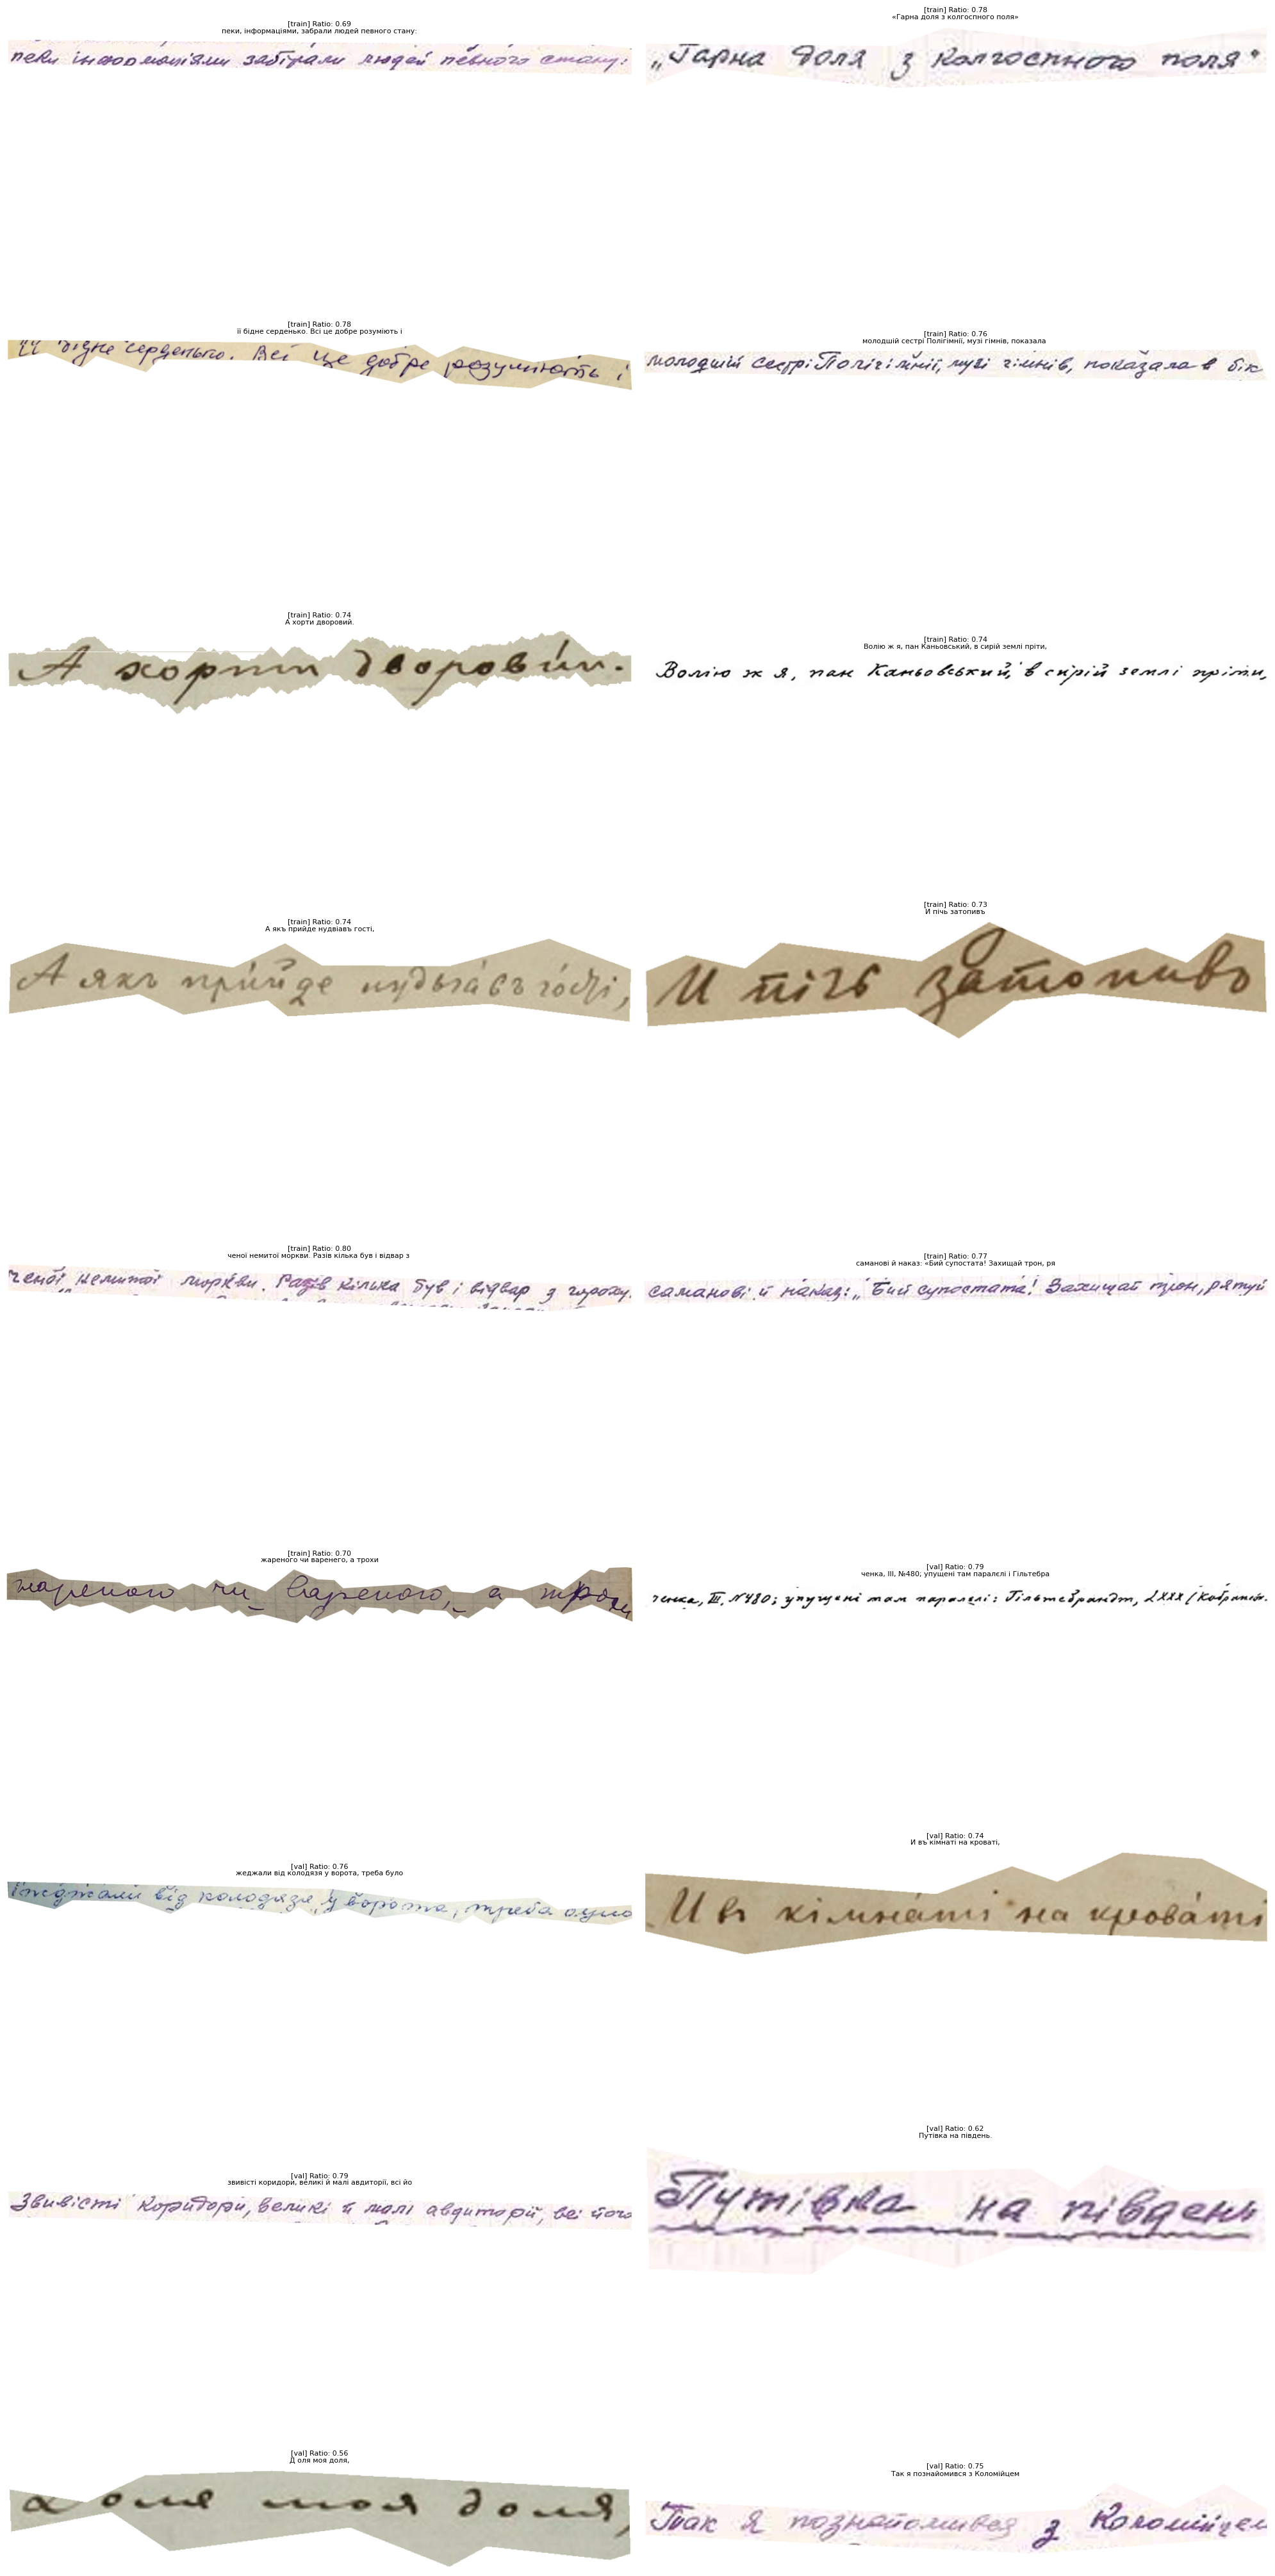

Flagged images saved to: ukrainian_v2_flagged_images.png


In [8]:
if flagged_images:
    print(f"Displaying {len(flagged_images)} flagged images...")
    
    n_cols = 2
    n_rows = (len(flagged_images) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, img_info in enumerate(flagged_images):
        img = Image.open(img_info['path'])
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(
            f"[{img_info['split']}] Ratio: {img_info['ratio']:.2f}\n{img_info['text']}",
            fontsize=8
        )
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(flagged_images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('ukrainian_v2_flagged_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Flagged images saved to: ukrainian_v2_flagged_images.png")
else:
    print("✅ No flagged images - all text is horizontal!")

## Dataset Statistics

In [9]:
# Calculate image dimensions for sampled images
train_widths = []
train_heights = []

for _, row in train_sample.iterrows():
    img_path = Path('data/pylaia_ukrainian_v2_train') / row['image_path']
    try:
        img = Image.open(img_path)
        train_widths.append(img.size[0])
        train_heights.append(img.size[1])
    except:
        pass

val_widths = []
val_heights = []

for _, row in val_sample.iterrows():
    img_path = Path('data/pylaia_ukrainian_v2_val') / row['image_path']
    try:
        img = Image.open(img_path)
        val_widths.append(img.size[0])
        val_heights.append(img.size[1])
    except:
        pass

print(f"{'='*60}")
print(f"IMAGE DIMENSION STATISTICS (Sampled Images)")
print(f"{'='*60}")
print(f"\nTraining set (n={len(train_widths)}):")
print(f"  Width:  {np.mean(train_widths):.1f} ± {np.std(train_widths):.1f} px (range: {np.min(train_widths)}-{np.max(train_widths)})")
print(f"  Height: {np.mean(train_heights):.1f} ± {np.std(train_heights):.1f} px (range: {np.min(train_heights)}-{np.max(train_heights)})")
print(f"  Aspect ratio: {np.mean(train_widths) / np.mean(train_heights):.1f}:1")

print(f"\nValidation set (n={len(val_widths)}):")
print(f"  Width:  {np.mean(val_widths):.1f} ± {np.std(val_widths):.1f} px (range: {np.min(val_widths)}-{np.max(val_widths)})")
print(f"  Height: {np.mean(val_heights):.1f} ± {np.std(val_heights):.1f} px (range: {np.min(val_heights)}-{np.max(val_heights)})")
print(f"  Aspect ratio: {np.mean(val_widths) / np.mean(val_heights):.1f}:1")

print(f"\n{'='*60}")
print(f"COMPARISON WITH OTHER DATASETS")
print(f"{'='*60}")
print(f"Church Slavonic: 42.8px avg height (reference: 3.17% CER)")
print(f"Prosta Mova V4:  64.0px avg height (reference: 4.60% CER)")
print(f"Ukrainian V2:    {np.mean(train_heights):.1f}px avg height (target: <10% CER)")
print(f"\nNote: Ukrainian has {np.mean(train_heights) / 42.8:.1f}x looser segmentation than Church Slavonic")

IMAGE DIMENSION STATISTICS (Sampled Images)

Training set (n=30):
  Width:  1605.5 ± 625.4 px (range: 498-2842)
  Height: 128.0 ± 0.0 px (range: 128-128)
  Aspect ratio: 12.5:1

Validation set (n=15):
  Width:  1328.2 ± 729.4 px (range: 588-2816)
  Height: 128.0 ± 0.0 px (range: 128-128)
  Aspect ratio: 10.4:1

COMPARISON WITH OTHER DATASETS
Church Slavonic: 42.8px avg height (reference: 3.17% CER)
Prosta Mova V4:  64.0px avg height (reference: 4.60% CER)
Ukrainian V2:    128.0px avg height (target: <10% CER)

Note: Ukrainian has 3.0x looser segmentation than Church Slavonic


## Summary

**Visual Inspection Complete**

- ✅ 30 training samples reviewed
- ✅ 15 validation samples reviewed
- ✅ Edge gradient analysis performed
- ✅ EXIF rotation check: 0 rotated images

**Next Steps**:
1. Review saved images: `ukrainian_v2_train_samples.png`, `ukrainian_v2_val_samples.png`
2. If no rotation issues found, proceed with training
3. Launch training: `./run_pylaia_ukrainian_v2_training.sh`